In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import os
import shutil

In [2]:
# Download and extract the Cats vs. Dogs dataset from Zenodo
!wget -O cats_and_dogs_small.zip https://zenodo.org/records/5226945/files/cats_dogs_light.zip?download=1
!unzip -q cats_and_dogs_small.zip -d /content/cats_and_dogs_small


--2025-08-06 02:31:01--  https://zenodo.org/records/5226945/files/cats_dogs_light.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32608921 (31M) [application/octet-stream]
Saving to: ‘cats_and_dogs_small.zip’

cats_and_dogs_small 100%[===================>]  31.10M  8.82MB/s    in 3.5s    

2025-08-06 02:31:06 (8.82 MB/s) - ‘cats_and_dogs_small.zip’ saved [32608921/32608921]



In [18]:
# Define dataset directory
dataset_dir = 'cats_and_dogs_small/cats_dogs_light'

# Create subdirectories for cats and dogs
for split in ['train', 'test']:
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(dataset_dir, split, category), exist_ok=True)

# Move images to correct subdirectories based on filename prefix
for split in ['train', 'test']:
    split_dir = os.path.join(dataset_dir, split)
    for fname in os.listdir(split_dir):
        if fname.startswith('cat.'):
            shutil.move(os.path.join(split_dir, fname), os.path.join(split_dir, 'cats', fname))
        elif fname.startswith('dog.'):
            shutil.move(os.path.join(split_dir, fname), os.path.join(split_dir, 'dogs', fname))

# Verify directory structure
print("Dataset directory contents:", os.listdir(dataset_dir))
print("Train directory contents:", os.listdir(os.path.join(dataset_dir, 'train')))
print("Test directory contents:", os.listdir(os.path.join(dataset_dir, 'test')))
print("Train cats directory contents:", len(os.listdir(os.path.join(dataset_dir, 'train', 'cats'))), "images")
print("Train dogs directory contents:", len(os.listdir(os.path.join(dataset_dir, 'train', 'dogs'))), "images")
print("Test cats directory contents:", len(os.listdir(os.path.join(dataset_dir, 'test', 'cats'))), "images")
print("Test dogs directory contents:", len(os.listdir(os.path.join(dataset_dir, 'test', 'dogs'))), "images")


Dataset directory contents: ['test', 'train']
Train directory contents: ['cats', 'dogs']
Test directory contents: ['cats', 'dogs']
Train cats directory contents: 455 images
Train dogs directory contents: 545 images
Test cats directory contents: 200 images
Test dogs directory contents: 200 images


In [20]:
# Load Cats vs. Dogs dataset
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),  # Using test as validation
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Check if generators found images
if train_generator.samples == 0 or validation_generator.samples == 0:
    raise ValueError("No images found in the dataset directories. Please check the directory structure.")


Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [21]:
# Build CNN model for binary classification
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [22]:
# Compile and build model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train model
model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5529 - loss: 0.9498 - val_accuracy: 0.5225 - val_loss: 0.6915
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5661 - loss: 0.6868 - val_accuracy: 0.5725 - val_loss: 0.6786
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6504 - loss: 0.6364 - val_accuracy: 0.6125 - val_loss: 0.6664
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6463 - loss: 0.6190 - val_accuracy: 0.6025 - val_loss: 0.6613
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7561 - loss: 0.5281 - val_accuracy: 0.6375 - val_loss: 0.6441


In [24]:
# Function to preprocess custom image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at {image_path}")
    img = cv2.resize(img, (150, 150))
    img = img.astype('float32') / 255.0
    img = img.reshape(1, 150, 150, 3)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


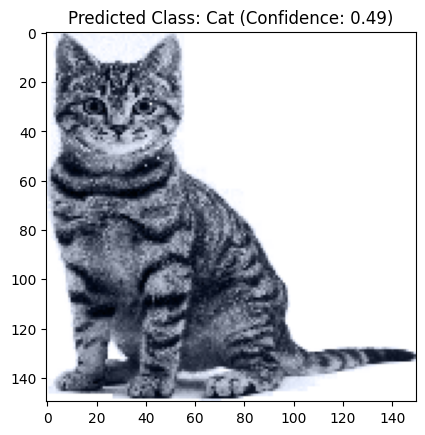

In [25]:
custom_img_path = 'cat.png'
custom_img = preprocess_image(custom_img_path)

# Test prediction
prediction = model.predict(custom_img)[0][0]
class_names = ['Cat', 'Dog']
predicted_class = 'Dog' if prediction > 0.5 else 'Cat'
plt.imshow(custom_img.reshape(150, 150, 3))
plt.title(f'Predicted Class: {predicted_class} (Confidence: {prediction:.2f})')
plt.show()